In [1]:
import pvdeg
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np

## Implemented PVLIB temperature models in PVDEG 

In [2]:
cell_temp = pvdeg.scenario.Scenario(
    name= 'cell temp',
    api_key='DEMO_KEY',
    email='user@mail.com',
)

cell_temp.addLocation(
    lat_long=(25.783388, -80.189029), 
    see_added=True,
)

cell_temp.addModule(
    module_name='module_1',
    racking='open_rack_glass_polymer',
    material='EVA',
    temperature_model='sapm',
    irradiance_args={'azimuth' : 120, 'tilt' : 30}, # check if this changes anything
    model_args={'irrad_ref' : 1100}, # check if this changes anything, if it doesnt then we have a problem
    see_added=True
)

cell_temp.addModule(
    module_name='module_2',
    racking='open_rack_glass_polymer',
    material='EVA',
    temperature_model='sapm',
    irradiance_args={'azimuth' : 180, 'tilt' : 0}, # check if this changes anything
    model_args={'irrad_ref' : 1100}, # check if this changes anything, if it doesnt then we have a problem
    see_added=True
)
cell_temp.addModule(
    module_name='module_3',
    racking='open_rack_glass_polymer',
    material='EVA',
    temperature_model='sapm',
    irradiance_args={'azimuth' : 120, 'tilt' : 30}, # check if this changes anything
    model_args={'irrad_ref' : 1000}, # check if this changes anything, if it doesnt then we have a problem
    see_added=True
)
cell_temp.addModule(
    module_name='module_4',
    racking='open_rack_glass_polymer',
    material='EVA',
    temperature_model='sapm',
    irradiance_args={'azimuth' : 180, 'tilt' : 0}, # check if this changes anything
    model_args={'irrad_ref' : 1000}, # check if this changes anything, if it doesnt then we have a problem
    see_added=True
)

cell_temp.updatePipeline(
    # func=pvdeg.standards.standoff,
    func=pvdeg.temperature.temperature,
    func_params={'cell_or_mod' : 'cell'}, # check this and change
    see_added=True
)

Column "relative_humidity" not found in DataFrame. Calculating...
Module "module_1" added.
Module "module_2" added.
Module "module_3" added.
Module "module_4" added.


C:\Users\tford\dev\PVDegradationTools\pvdeg\scenario.py:292: UserWarning: Gids Added - [1060699]
  warnings.warn(message, UserWarning)
C:\Users\tford\dev\PVDegradationTools\pvdeg\scenario.py:525: UserWarning: temperature added to pipeline as 
 {'job': <function temperature at 0x0000025B3C934D30>, 'params': {'cell_or_mod': 'cell'}}
  warnings.warn(message, UserWarning)


In [3]:
cell_temp

In [4]:
cell_temp.viewScenario()

Name : cell temp
Pipeline : 
                                            job params.cell_or_mod
0  <function temperature at 0x0000025B3C934D30>               cell
Results : Pipeline has not been run
'gids : [1060699]'
'test modules :'
{   'module_name': 'module_1',
    'racking': 'open_rack_glass_polymer',
    'material_params': {   'alias': 'EVA',
                           'Fickian': True,
                           'Ead': 29.43,
                           'Do': 0.13,
                           'Eas': 32.31,
                           'So': 87.8,
                           'Eap': 61.74,
                           'Po': 97900000000.0},
    'temp_model': 'sapm',
    'model_args': {'irrad_ref': 1100},
    'irradiance_args': {'azimuth': 120, 'tilt': 30}}
{   'module_name': 'module_2',
    'racking': 'open_rack_glass_polymer',
    'material_params': {   'alias': 'EVA',
                           'Fickian': True,
                           'Ead': 29.43,
                           'Do': 0.1

In [5]:
cell_temp.runPipeline()

pipeline results directory already exists
The array tilt angle was not provided, therefore the latitude tilt of 25.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
pipeline results directory already exists
The array tilt angle was not provided, therefore the latitude tilt of 25.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
pipeline results directory already exists
The array tilt angle was not provided, therefore the latitude tilt of 25.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
pipeline results directory already exists
The array tilt angle was not provided, therefore the latitude tilt of 25.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.


Text(0.5, 1.0, 'Single Day Cell (sapm) Temperature in $\\degree$C')

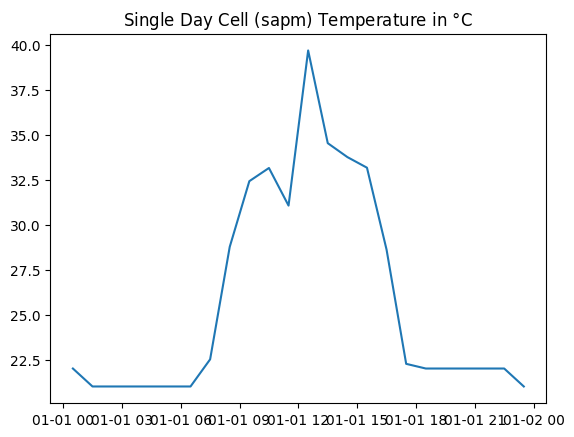

In [6]:
mod_1_temp = cell_temp.results['module_1']['temperature'][:24]

new_index = mod_1_temp.index.map(lambda dt: dt.replace(year=2000))

plt.plot(new_index, mod_1_temp)
plt.title('Single Day Cell (sapm) Temperature in $\degree$C')

In [7]:
display(pd.DataFrame([1,2,3,4,5]))

,0
0,1
1,2
2,3
3,4
4,5
